### Modules


In [1]:
# !pip install lightgbm
# !pip install xgboost


import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')


print("Done!")

Done!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #My google colab
# train_file = pd.read_csv('drive/My Drive/Challenge_Comps_Hacktons/Kaggle - Titanic Challenge/train.csv')
# test_file = pd.read_csv('drive/My Drive/Challenge_Comps_Hacktons/Kaggle - Titanic Challenge/test.csv')

#jupyter
train_file = pd.read_csv('train.csv')
test_file = pd.read_csv("test.csv")

#Target
y = train_file['Survived']

#Combining the test and train data
joint = pd.concat([train_file,test_file])

#Submission ID
sub_id = test_file['PassengerId']
print('Done')

Done


In [4]:
joint.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Missing values

print("Train:")
print(train_file.isnull().sum())

print("\nTest:")
print(test_file.isnull().sum())

Train:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
train_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_file.describe(percentiles=[0.2,0.3,0.7])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
20%,179.000000,0.000000,1.000000,19.000000,0.000000,0.000000,7.854200
30%,268.000000,0.000000,2.000000,22.000000,0.000000,0.000000,8.050000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
70%,624.000000,1.000000,3.000000,36.000000,1.000000,0.000000,27.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Visualizing Some of the Features

#### Parch and Sibsp

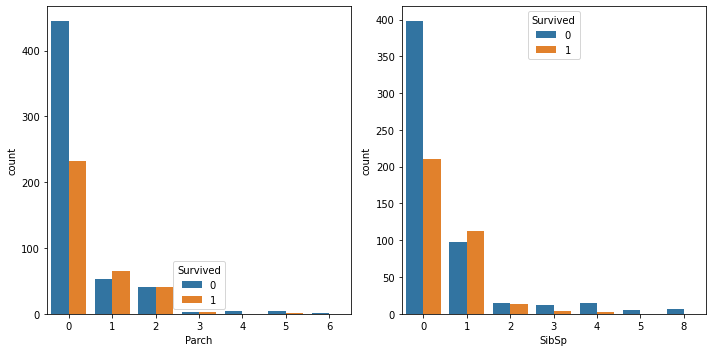

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.countplot(train_file.Parch, hue=train_file.Survived, ax=ax[0])
sns.countplot(train_file.SibSp, hue=train_file.Survived, ax=ax[1])
fig.tight_layout()

# From the chart we can see that:
# 1. A lot of people onboard were Alone
# 2. Those with Very Few Family Members had a higher Survival Rate

#### Sex

Survived
Sex    Survived          
female 1              233
       0               81
male   0              468
       1              109

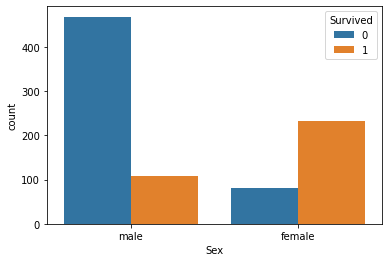

In [9]:
sns.countplot(train_file.Sex, hue=train_file.Survived)
# Majority of the Survivors were Females

pd.DataFrame(train_file.groupby('Sex').Survived.value_counts())
# 68% of the Survivors were Ladies

#### Pclass

Survived
Pclass Survived          
1      1              136
       0               80
2      0               97
       1               87
3      0              372
       1              119

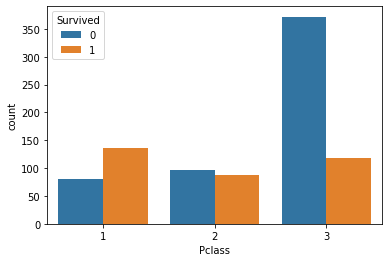

In [10]:
sns.countplot(train_file.Pclass, hue=train_file.Survived)
pd.DataFrame(train_file.groupby('Pclass').Survived.value_counts())

#From the chart:
#1. First Class Passengers had high survival rate (39%)
#2. Majority of the passengers (55%) are from Third Class, and
#3. Third Class passengers had the highest Death Rate (67%)

#### Embarked

Survived
Embarked Survived          
C        1               93
         0               75
Q        0               47
         1               30
S        0              427
         1              217

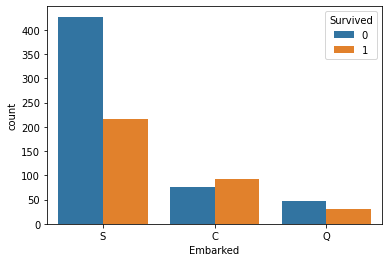

In [11]:
sns.countplot(train_file.Embarked, hue=train_file.Survived)
pd.DataFrame(train_file.groupby('Embarked').Survived.value_counts())

#From this chart wwe can see that:
#1. Majority of the people on board Embarked from 'S', and
#2. People from 'C' had higher Survival Rate

#### Fare

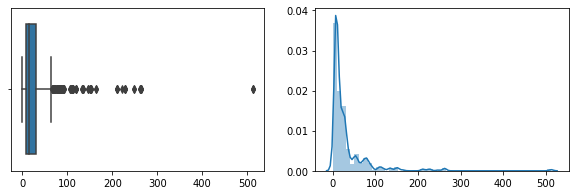

Skewedness:  4.787316519674893


In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(10,3))

x = ['Fare']
sns.boxplot(train_file[x], ax=ax[0])
sns.distplot(train_file[x], kde=True, ax=ax[1])
plt.show()

print("Skewedness: ",train_file.Fare.skew())

# The Fare column is skewed to the right
# Outliers are present

## Filling, Modifying and Adding New Features

In [13]:
# Filled the Embarked Column with "S" since it's the most occuring value
joint['Embarked'].fillna('S', inplace=True)

#Filled the Cabin Column with "Missing Info". The column will probably be dropped because of the large number of missing information
joint['Cabin'].fillna('Missing Info', inplace=True)

In [14]:
# joint.isna().sum()

#### Cabin Solution;

#### Grouping the cabins by their initials since they are similar


In [15]:
joint['Cabin'].head(6)

0    Missing Info
1             C85
2    Missing Info
3            C123
4    Missing Info
5    Missing Info
Name: Cabin, dtype: object

In [16]:
cabin_initials = []
all_cabins = list(joint.Cabin)

for x in range(0, len(all_cabins)):
    cabin_initials.append(all_cabins[x][0])

joint.Cabin = cabin_initials
set(joint.Cabin)

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T'}

In [17]:
joint.Cabin.head(6)

0    M
1    C
2    M
3    C
4    M
5    M
Name: Cabin, dtype: object

#### Adding the total family feature


In [18]:
joint['Total_Number_Family'] = joint['Parch'] + joint['SibSp'] + 1

#### Grouping the family into different sizes: Alone, Small, and Large

In [19]:
famsize = []
for val in joint['Total_Number_Family']:
    if val == 1:
        famsize.append('Alone')
    elif val in range(2,5):
        famsize.append('Small_Family')
    elif val > 4:
        famsize.append("Large_Family")

joint['Famsize'] = famsize

In [20]:
#### Extracting the Salutaion feature from the Name Column


In [21]:
joint['Salutation'] = joint.Name.str.split(',').str[1].str.split('.').str[0].str.strip()

joint["Salutation"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

#### Simpilifing the salutation feature


In [22]:
Salutation_simp = []
for val in joint['Salutation']:
    if val in ['Mr', 'Don',  'Major', 'Jonkheer', 'Rev', 'Dr']:
        Salutation_simp.append('Mr')

    elif val in ['Mrs', 'Dona', 'Mme','Lady','the Countess',]:
        Salutation_simp.append('Mrs')

    elif val == 'Master':
        Salutation_simp.append('Master')

    elif val in ['Miss', 'Mlle']:
        Salutation_simp.append('Miss')
    else:
        Salutation_simp.append('Military')

joint["Salutation_simp"] = Salutation_simp

joint["Salutation_simp"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Military'], dtype=object)

#### Grouping the Age Column by the median based on; Pclass, Salutation and Sex.


In [23]:
x = joint.groupby(['Pclass','Salutation_simp','Sex']).median()
grouped_median_train = x['Age'].reset_index()
grouped_median_train

,Pclass,Salutation_simp,Sex,Age
0,1,Master,male,6.0
1,1,Military,male,54.5
2,1,Miss,female,30.0
3,1,Mr,female,49.0
4,1,Mr,male,42.0
5,1,Mrs,female,45.0
6,2,Master,male,2.0
7,2,Military,female,28.0
8,2,Miss,female,20.0
9,2,Mr,male,30.0


### Filling the Missing Age Column with the corresponding median value from the following grouping; Pclass, Salutation and Sex.
#### i.e.
#### If the passenger is a 'Male', has a 'Military' salutation, and has a Pclass of '1', it fills the missing Age cell with '54.5'

### I got this tip from:
[ahmedbesbes](https://github.com/ahmedbesbes/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/article_1.ipynb)

In [24]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Salutation_simp'] == row['Salutation_simp']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global joint
    joint['Age'] = joint.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    return joint

joint = process_age()

In [25]:
joint.isnull().sum()

PassengerId              0
Survived               418
Pclass                   0
Name                     0
Sex                      0
Age                      1
SibSp                    0
Parch                    0
Ticket                   0
Fare                     1
Cabin                    0
Embarked                 0
Total_Number_Family      0
Famsize                  0
Salutation               0
Salutation_simp          0
dtype: int64

#### Grouping the Fare by the Pclass to find the suitable median for the missing value

In [26]:
print(joint['Fare'].groupby(joint['Pclass']).median())
joint['Fare'].fillna(( joint['Fare'].groupby(joint['Pclass']).median() )[3], inplace=True)

Pclass
1    60.0000
2    15.0458
3     8.0500
Name: Fare, dtype: float64


#### Grouping the Age by the Pclass to find the suitable median for the missing value

In [27]:
print(joint['Age'].groupby(joint['Pclass']).median())
joint['Age'].fillna(joint['Age'].groupby(joint['Pclass']).median()[3], inplace=True)

Pclass
1    42.0
2    29.0
3    26.0
Name: Age, dtype: float64


#### Seprating the Age into different groups; Adult, Teen etc...

In [28]:
joint.Age = round(joint.Age)

Age_group = []

for val in joint.Age:
    if val in range(0,14):
        Age_group.append("Child")
    elif val in range(14,19):
        Age_group.append("Teen")
    elif val in range(19,30):
        Age_group.append("Youth")
    elif val in range(30,70):
        Age_group.append("Adult")
    else:
        Age_group.append("Elder")
joint['Age_group'] = Age_group

#### Seprating the Fare into different groups; Expensive, Cheap etc...

In [29]:
Fare_group = []

for x in round(joint.Fare):
    if x in range(0,51):
        Fare_group.append('Cheap')
    elif x in range(51,101):
        Fare_group.append('Moderate')
    else:
        Fare_group.append('Expensive')
joint['Fare_group'] = Fare_group

#### Wealth Status



In [30]:
status = []
for w,v in zip(joint['Pclass'], joint['Fare_group']):
    if (w == 1) and (v == 'Expensive'):
        status.append('Wealthy') 
    else:
        status.append('Not Wealthy')

joint['status'] = status

#### Wealth Status + Gender

In [31]:
gend_stat = []

for w,v in zip(joint['Sex'], joint['status']):
    gend_stat.append(f'{w}_{v}')
joint['gend_stat'] = gend_stat

#### Family Status

In [32]:
fam_stat = []
for val in joint.Total_Number_Family:
    if val == 1:
        fam_stat.append('Single')
    elif val == 2:
        fam_stat.append('Married')
    else:
        fam_stat.append('Married_w_kids')
joint['fam_stat'] = fam_stat

#### Dropping irrelevant features

In [33]:
final_drop = ['PassengerId','Name','Ticket','Salutation', 'Cabin']
joint.drop(final_drop,1, inplace=True)

In [34]:
### Splitting the Joint data back to Train and Test Data

In [35]:
Train = joint[:891]
Test = joint[-418:]

In [36]:
Train.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Total_Number_Family,Famsize,Salutation_simp,Age_group,Fare_group,status,gend_stat,fam_stat
0,0.0,3,male,22.0,1,0,7.2500,S,2,Small_Family,Mr,Youth,Cheap,Not Wealthy,male_Not Wealthy,Married
1,1.0,1,female,38.0,1,0,71.2833,C,2,Small_Family,Mrs,Adult,Moderate,Not Wealthy,female_Not Wealthy,Married
2,1.0,3,female,26.0,0,0,7.9250,S,1,Alone,Miss,Youth,Cheap,Not Wealthy,female_Not Wealthy,Single
3,1.0,1,female,35.0,1,0,53.1000,S,2,Small_Family,Mrs,Adult,Moderate,Not Wealthy,female_Not Wealthy,Married
4,0.0,3,male,35.0,0,0,8.0500,S,1,Alone,Mr,Adult,Cheap,Not Wealthy,male_Not Wealthy,Single


### More Visualization...

#### Family Size and Total Family

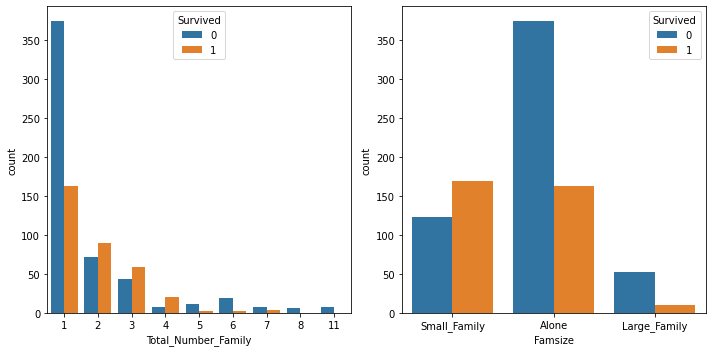

In [37]:
# pd.DataFrame(Train.groupby('Total_Number_Family').Survived.value_counts())

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.countplot(Train.Total_Number_Family, hue=train_file.Survived, ax=ax[0])
sns.countplot(Train.Famsize, hue=train_file.Survived, ax=ax[1])
fig.tight_layout()

#Once again we see that Families of (2-4) members had a higher Survival rate

#### Cabin

In [38]:
# plt.figure(figsize=(10,7))
# sns.countplot(Train.Cabin, hue=train_file.Survived)

#### From the chart above, passengers from Cabin GFTADCB make a a very little fraction, therefore:

In [39]:
# Cabin_ = []
# for val in joint.Cabin:
#     if val in ['G', 'F', 'T', 'A', 'D','C', 'B',]:
#         Cabin_.append('Irr')
#     else:
#         Cabin_.append(val)
# joint.Cabin = Cabin_

#### Age

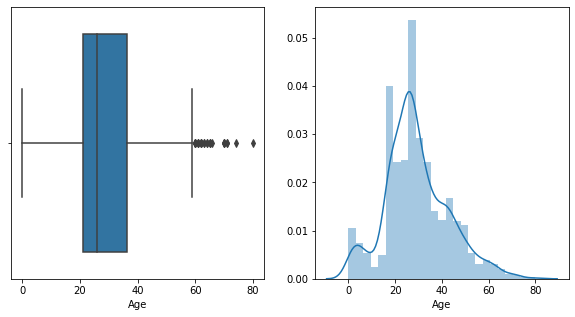

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.boxplot(Train.Age, ax=ax[0])
sns.distplot(Train.Age, ax=ax[1])

#The Age Feature is somewhat Normally Distributed and has very few outliers

#### Age Group

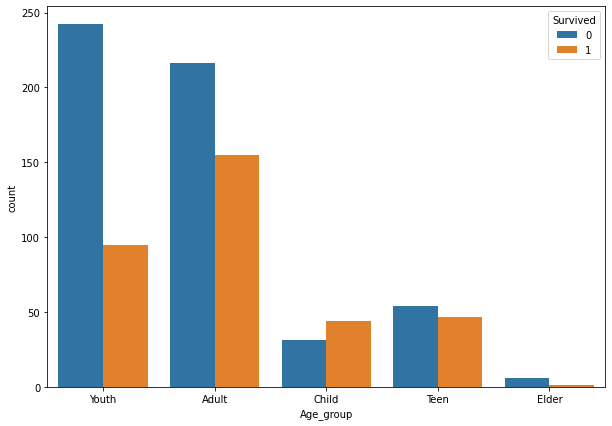

In [41]:
plt.figure(figsize=(10,7))
sns.countplot(Train.Age_group, hue=train_file.Survived)

#### Salutation 

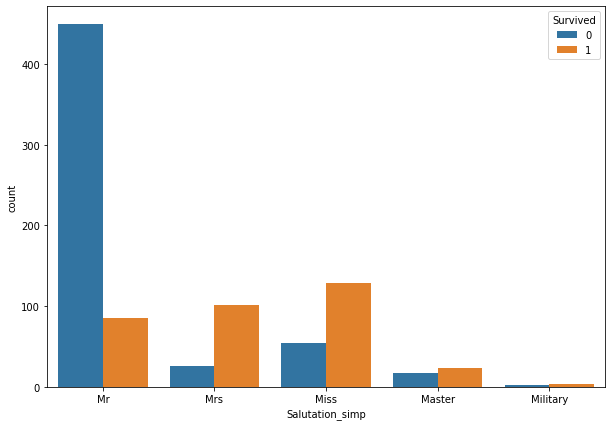

In [42]:
plt.figure(figsize=(10,7))
sns.countplot(Train.Salutation_simp, hue=train_file.Survived)

#### Fare Group

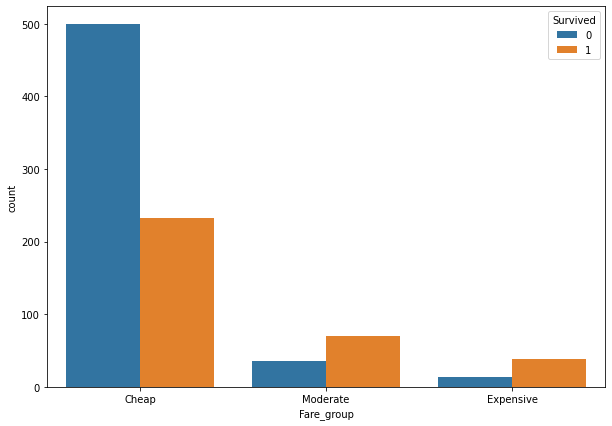

In [43]:
plt.figure(figsize=(10,7))
sns.countplot(Train.Fare_group, hue=train_file.Survived)

#### Wealth Status

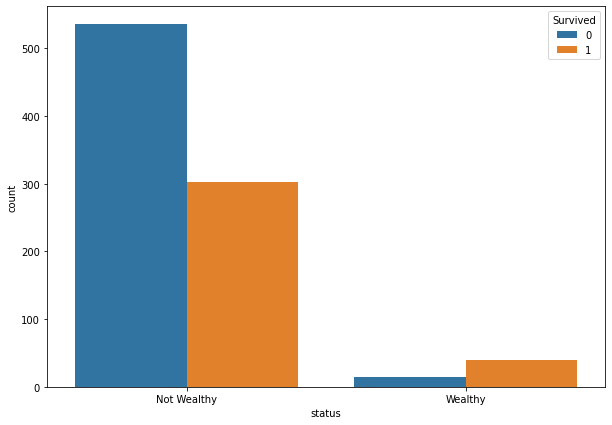

In [44]:
plt.figure(figsize=(10,7))
sns.countplot(Train.status, hue=train_file.Survived)

#### Gender + Wealth Status

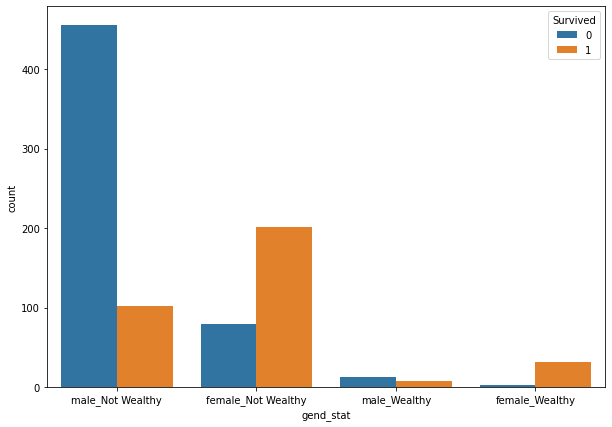

In [45]:
plt.figure(figsize=(10,7))
sns.countplot(Train.gend_stat, hue=train_file.Survived)

#### Family Status


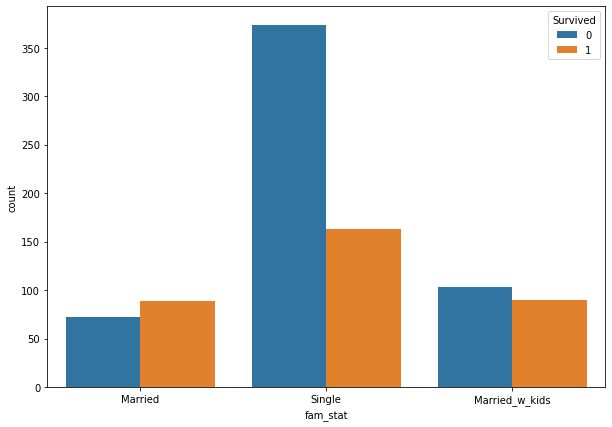

In [46]:
plt.figure(figsize=(10,7))
sns.countplot(Train.fam_stat, hue=train_file.Survived)

In [47]:
joint.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Total_Number_Family,Famsize,Salutation_simp,Age_group,Fare_group,status,gend_stat,fam_stat
0,0.0,3,male,22.0,1,0,7.2500,S,2,Small_Family,Mr,Youth,Cheap,Not Wealthy,male_Not Wealthy,Married
1,1.0,1,female,38.0,1,0,71.2833,C,2,Small_Family,Mrs,Adult,Moderate,Not Wealthy,female_Not Wealthy,Married
2,1.0,3,female,26.0,0,0,7.9250,S,1,Alone,Miss,Youth,Cheap,Not Wealthy,female_Not Wealthy,Single
3,1.0,1,female,35.0,1,0,53.1000,S,2,Small_Family,Mrs,Adult,Moderate,Not Wealthy,female_Not Wealthy,Married
4,0.0,3,male,35.0,0,0,8.0500,S,1,Alone,Mr,Adult,Cheap,Not Wealthy,male_Not Wealthy,Single


In [48]:
# lenc_data = ['Sex']#, 'Cabin', 'Embarked', 'Alone_Famsize', 'Salutation']
# for data in lenc_data:
#     joint[data] = LabelEncoder().fit_transform(joint[data])

In [49]:
### Dummy Encoding the Categorical variables

### Dummy Encoding the Categorical variables

In [50]:
joint = pd.get_dummies(joint)
joint.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Total_Number_Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Famsize_Alone,Famsize_Large_Family,Famsize_Small_Family,Salutation_simp_Master,Salutation_simp_Military,Salutation_simp_Miss,Salutation_simp_Mr,Salutation_simp_Mrs,Age_group_Adult,Age_group_Child,Age_group_Elder,Age_group_Teen,Age_group_Youth,Fare_group_Cheap,Fare_group_Expensive,Fare_group_Moderate,status_Not Wealthy,status_Wealthy,gend_stat_female_Not Wealthy,gend_stat_female_Wealthy,gend_stat_male_Not Wealthy,gend_stat_male_Wealthy,fam_stat_Married,fam_stat_Married_w_kids,fam_stat_Single
0,0.0,3,22.0,1,0,7.2500,2,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0
1,1.0,1,38.0,1,0,71.2833,2,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0
2,1.0,3,26.0,0,0,7.9250,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1
3,1.0,1,35.0,1,0,53.1000,2,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0
4,0.0,3,35.0,0,0,8.0500,1,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1


#### Scaling the Continous features

In [51]:
scale_it = ['Age', 'Fare', 'Total_Number_Family', 'SibSp', 'Parch']
joint[scale_it] = MinMaxScaler().fit_transform(joint[scale_it])
joint.drop(['Survived'],1, inplace=True)
# joint = MinMaxScaler().fit_transform(joint)

In [52]:
# # final_drop = ['SibSp', 'Parch']
# last_vals = ['Cabin_G','Embarked_S','Alone_Famsize_Alone','Salutation_Honorary','Cabin_T']
# joint.drop(last_vals,1,inplace=True)

### Training and Validation Data

In [54]:
Train = joint[:891]
Test = joint[-418:]
x_train, x_test, y_train, y_test = tts(Train, y, test_size= 0.15, random_state=0)

In [55]:
Train.head()

,Pclass,Age,SibSp,Parch,Fare,Total_Number_Family,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Famsize_Alone,Famsize_Large_Family,Famsize_Small_Family,Salutation_simp_Master,Salutation_simp_Military,Salutation_simp_Miss,Salutation_simp_Mr,Salutation_simp_Mrs,Age_group_Adult,Age_group_Child,Age_group_Elder,Age_group_Teen,Age_group_Youth,Fare_group_Cheap,Fare_group_Expensive,Fare_group_Moderate,status_Not Wealthy,status_Wealthy,gend_stat_female_Not Wealthy,gend_stat_female_Wealthy,gend_stat_male_Not Wealthy,gend_stat_male_Wealthy,fam_stat_Married,fam_stat_Married_w_kids,fam_stat_Single
0,3,0.2750,0.125,0.0,0.014151,0.1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0
1,1,0.4750,0.125,0.0,0.139136,0.1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0
2,3,0.3250,0.000,0.0,0.015469,0.0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,1
3,1,0.4375,0.125,0.0,0.103644,0.1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0
4,3,0.4375,0.000,0.0,0.015713,0.0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1


In [56]:
## Creating The Models

#### Simple Random Forest Algorithm

In [57]:
for n in [50,100,150,200,250,300]:
    rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, n_estimators=n)
    rfc.fit(x_train,y_train)
    pred = rfc.predict(x_test)
    print(f"{n}: {accuracy_score(y_test,pred)}")

50: 0.8283582089552238
100: 0.8283582089552238
150: 0.8283582089552238
200: 0.8283582089552238
250: 0.8283582089552238
300: 0.8283582089552238


In [58]:
confusion_matrix(y_test, pred)

array([[71,  8],
       [15, 40]])

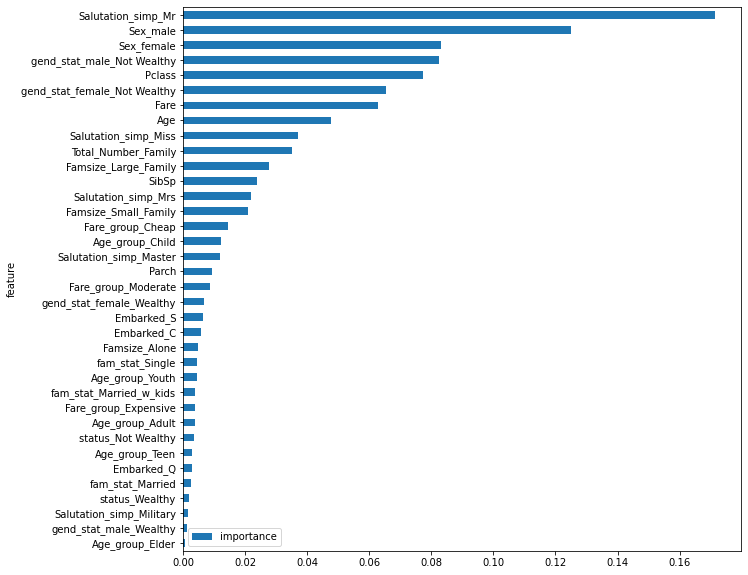

In [59]:
#Checking importance of each feature
%matplotlib inline
features = pd.DataFrame()
features['feature'] = Train.columns
features['importance'] = rfc.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(10,10))

In [60]:
# from sklearn.feature_selection import SelectFromModel

# model = SelectFromModel(rfc, prefit=True)
# Train = model.transform(Train)
# Test = model.transform(Test)
# print(Train.shape)

# x_train, x_test, y_train, y_test = tts(Train, y, test_size= 0.15, random_state=0)

### Random Forest Grid Search



In [61]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score

kf = StratifiedKFold(n_splits=5)

In [62]:
parameters = {
    'n_estimators' : [10,50,100,150],
    # 'n_jobs': '-1',
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [2,4,6],
    'criterion' :['gini', 'entropy'],
                #  'min_samples_split': [2, 3, 10],
                #  'min_samples_leaf': [1, 3, 10],
                #  'bootstrap': [True, False],

}

rfc_gridcv = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=kf, verbose=0)

rfc_gridcv.fit(Train, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                         

In [63]:
rfc_after_search = RandomForestClassifier(n_estimators = rfc_gridcv.best_params_['n_estimators'],
                                          max_features=rfc_gridcv.best_params_['max_features'],
                                          max_depth=rfc_gridcv.best_params_['max_depth'],
                                        #   min_samples_leaf = rfc_gridcv.best_params_['min_samples_leaf'],
                                        #   min_samples_split = rfc_gridcv.best_params_['min_samples_split'],
                                        #   bootstrap= rfc_gridcv.best_params_['bootstrap'],
                                          criterion= 'entropy' ,#rfc_gridcv.best_params_['criterion'], 
                                          verbose = 0)

rfc_after_search.fit(x_train,y_train)

rfc_after_search_pred = rfc_after_search.predict(x_test)

print('Accuracy Score: ', accuracy_score(y_test, rfc_after_search_pred))

Accuracy Score:  0.8283582089552238


In [64]:
confusion_matrix(y_test, rfc_after_search_pred)

array([[71,  8],
       [15, 40]])

#### Random Forest Cross validation

In [65]:
rfc_cvscore = cross_val_score(rfc_after_search,Train,y,scoring = 'accuracy',cv=kf)
print(rfc_cvscore)
print('Average CV: ',sum(rfc_cvscore)/5)

[0.84357542 0.8258427  0.8258427  0.79775281 0.85955056]
Average CV:  0.8305128366078716


### Adaboost Grid Search

In [66]:
n_estimators = [50,100,150,200]#,150,160, 170,175,180,185];
learning_r = [0.1,1,0.01,0.5]

ada_parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_r
              
        }
ada_grid = GridSearchCV(AdaBoostClassifier(base_estimator= rfc_after_search, 
                                     ),
                                 param_grid=ada_parameters,
                                 cv=kf,
                                 n_jobs = -1,
                                 verbose=0
                                 )
ada_grid.fit(Train,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=RandomForestClassifier(bootstrap=True,
                                                                                ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='entropy',
                                                                                max_depth=4,
                                                                                max_features='sqrt',
                                                                                max_leaf_nodes=None,
                                                                                max_samples=None,
                                            

In [67]:
ada_after_grid = AdaBoostClassifier(algorithm='SAMME.R', 
                                    base_estimator= rfc_after_search, 
                                    n_estimators=ada_grid.best_params_['n_estimators'], 
                                    learning_rate=ada_grid.best_params_['learning_rate'])
ada_after_grid.fit(x_train,y_train)
ada_after_grid_pred = ada_after_grid.predict(x_test)
accuracy_score(y_test, ada_after_grid_pred)

0.8283582089552238

In [68]:
confusion_matrix(y_test, ada_after_grid_pred)

array([[71,  8],
       [15, 40]])

### Adaboost cross validation

In [69]:
ada_score = cross_val_score(ada_after_grid,Train,y,scoring = 'accuracy',cv=kf)
print(ada_score)
print('Average CV: ',sum(ada_score)/5)

[0.83333333 0.87640449 0.7752809  0.87640449 0.84269663 0.80898876
 0.83146067 0.79775281 0.86516854 0.85393258]
Average CV:  0.8361423220973782


### XGBoost Grid Search

In [70]:
xgb_params = {
        'n_estimators': [50,100, 150,200, 500],
        'subsample': [0.6, 1.0],
        'max_depth': [2,5,8],
        'learning_rate': [0.1,0.01,0.02],
        "min_samples_split": [2,5,10]
        }

xg_grid = GridSearchCV(XGBClassifier(), param_grid=xgb_params, cv = kf, n_jobs = -1, verbose=1)
xg_grid.fit(Train,y)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  5.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:...
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02],
                         'max_depth': [2, 5, 8],
   

In [71]:
xgb_after_cv = XGBClassifier(learning_rate = xg_grid.best_params_["learning_rate"], 
                    max_depth = xg_grid.best_params_["max_depth"],
                    min_samples_split = xg_grid.best_params_["min_samples_split"],
                    n_estimators = xg_grid.best_params_["n_estimators"],
                    subsample = xg_grid.best_params_["subsample"])
xgb_after_cv.fit(x_train,y_train)
xgb_after_cv_pred = xgb_after_cv.predict(x_test)
accuracy_score(y_test, xgb_after_cv_pred)

0.835820895522388

In [72]:
confusion_matrix(y_test, xgb_after_cv_pred)

array([[74,  5],
       [17, 38]])

#### XGboost cross validation

In [73]:
xg_cvscore = cross_val_score(xgb_after_cv,Train,y,scoring = 'accuracy',cv=kf)
print('Average CV: ',sum(xg_cvscore)/5)

Average CV:  0.8451560549313358


### Bagging

#### Basic


In [74]:
for n in [10,20,50,100]:
    bag = BaggingClassifier(RandomForestClassifier(), max_features=1.0, max_samples=80, n_estimators=n, n_jobs=-1, verbose=0)
    bag.fit(x_train,y_train)
    bag_pred = bag.predict(x_test)

    print(n, accuracy_score(y_test, bag_pred))
confusion_matrix(y_test, bag_pred)

10 0.8208955223880597
20 0.8283582089552238
50 0.835820895522388
100 0.835820895522388


array([[72,  7],
       [15, 40]])

#### Advanced

In [75]:
param_grid = {
    'max_features' : [1.0, 0.5],
    'max_samples' : [0.1, 0.2, 0.5,0.8],
    'base_estimator' : [RandomForestClassifier(), DecisionTreeClassifier()]
}

bag_search = GridSearchCV(BaggingClassifier(n_estimators=100),param_grid=param_grid, verbose=1, cv=kf)
bag_search.fit(Train,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 11.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
                                         bootstrap_features=False,
                                         max_features=1.0, max_samples=1.0,
                                         n_estimators=100, n_jobs=None,
                                         oob_score=False, random_state=None,
                                         verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'base...
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
            

In [76]:
bag_search.best_params_

{'base_estimator': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'max_features': 1.0,
 'max_samples': 0.8}

In [77]:
bag_after_cv = BaggingClassifier(
                    max_features = bag_search.best_params_["max_features"],
                    max_samples = bag_search.best_params_["max_samples"],
                    base_estimator = bag_search.best_params_["base_estimator"]
                    )
bag_after_cv.fit(x_train,y_train)
bag_after_cv_pred = bag_after_cv.predict(x_test)
accuracy_score(y_test, bag_after_cv_pred)

0.8656716417910447

#### Bagging CV Score

In [78]:
bag_cvscore = cross_val_score(bag_after_cv,Train,y,scoring = 'accuracy',cv=kf)
print('Average CV: ',sum(bag_cvscore)/5)

Average CV:  0.8305442219571905


### Combining the results from all models and Casting a vote for the Final Predictions

In [79]:
# Predictions Table
prediction_table = pd.DataFrame()

In [80]:
prediction_table['xg'] = xgb_after_cv_pred
prediction_table['rfc'] = rfc_after_search_pred
prediction_table['ada'] = ada_after_grid_pred
prediction_table['bag'] = bag_after_cv_pred

prediction_table.head(10)

,xg,rfc,ada,bag
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,1,1,1,1
4,0,1,1,1
5,0,0,0,0
6,1,1,1,1
7,1,1,1,1
8,0,0,0,0
9,1,1,1,1


In [81]:
final_pred = round((prediction_table['xg']+prediction_table['rfc']+prediction_table['ada']+prediction_table['bag']) / 4, 0)

In [82]:
confusion_matrix(y_test,final_pred)

array([[71,  8],
       [15, 40]])

### Submissions

In [83]:
rfc_after_search.fit(Train,y)
rfc_sub = pd.DataFrame({
    'PassengerID': sub_id,
    'Survived': rfc_after_search.predict(Test)
})

rfc_sub.to_csv('Random_Forest_submission.csv', index=False)
print("Done")

Done


In [84]:
xgb_after_cv.fit(Train,y)

xg_sub = pd.DataFrame({
    'PassengerID': sub_id,
    'Survived': xgb_after_cv.predict(Test)
})

xg_sub.to_csv('Xg_submission.csv', index=False)
print("Done")

Done


In [85]:
ada_after_grid.fit(Train,y)
ada_sub = pd.DataFrame({
    'PassengerID': sub_id,
    'Survived': ada_after_grid.predict(Test)
})

ada_sub.to_csv('Ada_submission.csv', index=False)
print("Done")

Done


In [86]:
bag_after_cv.fit(Train,y)
bag_sub = pd.DataFrame({
    'PassengerID': sub_id,
    'Survived': bag.predict(Test)
})

bag_sub.to_csv('Bag_submission.csv', index=False)
print("Done")

Done


#### Combined Submission Prediction


In [87]:
comb_sub = pd.DataFrame()

In [88]:
comb_sub['xg'] = xg_sub.Survived
comb_sub['rfc'] = rfc_sub.Survived
comb_sub['ada'] = ada_sub.Survived
comb_sub['bag'] = bag_sub.Survived

comb_sub.head(5)

,xg,rfc,ada,bag
0,0,0,0,0
1,0,1,1,1
2,0,0,0,0
3,0,0,0,0
4,1,1,1,1


In [89]:
final_sub = round((comb_sub['xg']+comb_sub['rfc']+comb_sub['ada']+comb_sub['bag']) / 4, 0)
fin_sub = []
for val in final_sub:
    fin_sub.append(int(val))
final_sub = fin_sub

In [90]:
combined_sub = pd.DataFrame({
    'PassengerID': sub_id,
    'Survived': final_sub
})

combined_sub.to_csv('combined_sub.csv', index=False)
print("Done")

Done


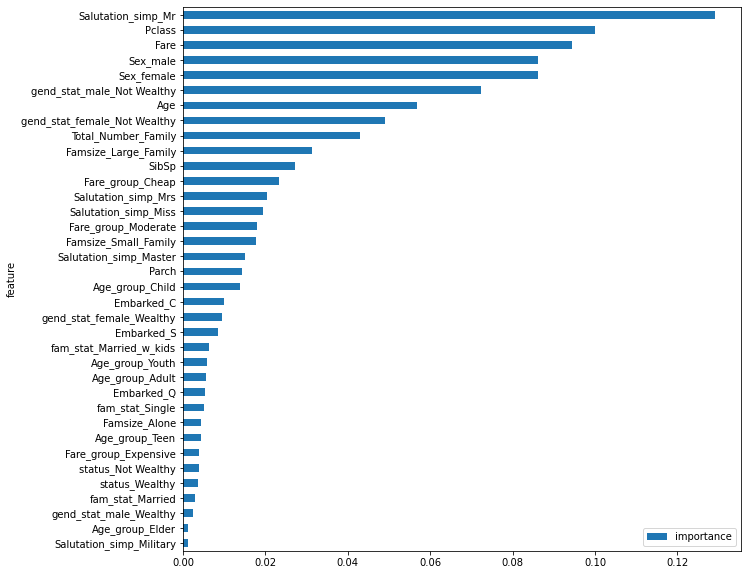

In [94]:
#Checking importance of each feature
features = pd.DataFrame()
features['feature'] = Train.columns
features['importance'] = ada_after_grid.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(10,10))